# Learning embeddings into entropic Wasserstein spaces :  résumé théorique et application à word2cloud.

Par Romain Ait Abdelmalek (M2 StatML, Paris-Sud). D'après un article de Charlie Frogner, Farzaneh Mirzazadeh et Justin Solomon.

Ce projet se décompose de la manière suivante : 

- Un script, permettant d'entrainer les réseaux de neurones. A noter que ce script prend en argument la paramètre M décrivant le nombre de point de support des lois cibles.
- Ce notebook, contenant un résumé des points importants de l'article et un commentaire de l'implémentation de word2cloud et des résultats obtenus.
- Le fichier text8, utilisé pour l'entrainement des réseaux de neurones.
- Deux exemplaires du réseau de neurones entrainé, pour M = 2 et M = 5.

## 1 ) Embeddings et espaces de Wasserstein

Pour des raisons de visualisation des données, ou afin de permettre la réduction de certains calculs, il peut être utile de réaliser un "embedding". C'est-à-dire de représenter des données d'un espace $A$, souvent d'un espace en grande dimension, dans un espace de plus petite dimension $B$. Afin d'être efficace, cet embedding se doit de préserver les relations entre les différents élements de l'espace de départ, par exemple les distances.

L'idée est donc de trouver une fonction $\Phi$ de $A$ dans $B$ telle que $\forall u,v \in A$ :

\begin{align*} Ld_A(u,v) \le d_B(\Phi(u),\Phi(v)) \le CLd_A(u,v) \end{align*}

Où $L > 0$ et $C \ge 1$ représente la distorsion induite par l'embedding.



L'objet principal de cet article est d'étudier l'embedding à destination des espaces de Wasserstein d'un espace $X$. Ces espaces de Wassertein $W_p(X)$ sont les espaces de mesures de probabilités sur $X$ tels que $\forall \mu,\nu$ mesures de probabilités sur $X$, on a : 

\begin{align*} W_p(\mu,\nu) = \left(\inf_{\pi} \int_{X^2}d(x_1,x_2)d\pi(x_1,x_2)\right)^{\frac{1}{p}} < \infty\end{align*}

Où l'infimum est pris sur l'ensemble des couplages $\pi$ entre les lois $\mu$ et $\nu$, et $d$ est une distance sur l'espace $X$.

L'utilisation des espaces de Wasserstein comme espaces de destination d'un embedding présente un avantage considérable. En effet, ces derniers possèdent une capacité de représentation importante, de part le fait qu'il est possible, pour tout $A$ espace métrique et pour tout $k \in N$, de trouver un embedding de $A^k$ vers $W_p(A)$. Mieux encore, il est possible de trouver un tel embedding tel que pour tout $u \in A$, $\Phi(u)$ soit une distribution à support fini.


## 2) Le problème d'apprentissage

Supposons désormais que l'on dispose d'un ensemble $C$, d'une relation $r : C^2 \rightarrow R$ (typiquement, une distance), et d'un échantillon $S = \{(u^{(i)},v^{(i)}, r(u^{(i)},v^{(i)})\}$. Comme expliqué dans la section précèdente, notre but va être d'obtenir une application $\Phi : C \rightarrow W_p(X)$ tel que la relation $r$ entre les éléments de notre échantillon soit préservée au maximum. Afin d'obtenir des résultats visualisables, on fixe $X = R^2$.

Le premier point important est de définir plus précisement l'ensemble d'arrivée de notre fonction $\Phi$. Ainsi, dans l'article, on se réduit au sous-ensemble des distributions sur $R^2$ dont le support est de cardinalité $M$, et de poids uniforme sur ce support. Nous notons ce sous-ensemble $H$.

Le second point important est que la distance $W_p(\mu,\nu)^p$ (prise à la puissance p pour des raisons pratiques) est extrêment couteuse à calculer. Ainsi, il est nécessaire d'en utiliser une approximation en utilisant la divergence de Sinkhorn $W_p^{\lambda}$, définie comme suit : 

\begin{align*} W_p^{\lambda}(u,v) = \min_{T \ge 0}tr(D^pT^t) + \lambda tr (T(\log(T)-11^t)^t)\end{align*}

tel que $T1 = u$ et $T^t1 = v$, où $1$ représente le vecteur unité de $R^M$ et $D$ est la matrice définie par :

\begin{align*} D_{i,j} = d(u^{(i)},v^{(j)}) \end{align*}

La résolution en $T$ de ce problème s'écrit $Diag(r)\exp\left(-D^p/\lambda\right)Diag(c)$. Il est possible de l'approximer par matrice balancing. Plus précisement, on associe à tour de rôle : 
\begin{align*} r = u/\exp\left(-D^p/\lambda\right)c \quad \text{et} \quad c = v/\exp\left(-D^p/\lambda\right)r\end{align*}

A noter que les puissances, la division et le logarithme sont ici considérés éléments par éléments. En remarquant que $W_p(\mu,\nu)^p = \min_{T \ge 0} tr(D^pT^t)$, on approxime la distance de Wasserstein en utilisant la matrice T obtenue pour la divergence de Sinkhorn.

Le problème de recherche de la fonction $\Phi$ peut ainsi se résumer au problème de minimisation suivant, avec une perte $L$ : 

\begin{align*} \Phi^* = \arg\min_{\Phi \in H} \sum_{i=1}^{N}L\left(\tilde{W}_p^{\lambda}(\Phi(u^{(i)}),\Phi(v^{(i)})), r^{(i)}\right)\end{align*}

Où $\tilde{W}_p^{\lambda}(\Phi(u^{(i)}),\Phi(v^{(i)}))$ est l'approximation de la distance de Wasserstein.

Pour un choix correct de perte $L$, le problème précèdent est ainsi résoluble par automatic différentiation.

## 3 ) Implémentation : word2cloud

On considère le fichier text8, composé de 17M de tokens issus de Wikipédia.en. Le fichier ne comprend aucune ponctuation. Le but de word2cloud est de regrouper les mots qui ont tendance à être de même contexte. Plus précisement, on dit qu'un mot est dans le contexte d'un autre si ils sont à moins de deux mots d'intervalle dans une même phrase. A l'inverse, on veut espacer les mots qui n'ont pas tendance à être de même contexte d'une distance minimale fixée à 1.

Il s'agit ainsi de résoudre :

\begin{align*} \Phi^* = \arg\min_\Phi \sum_{phrase}\sum_{m1,m2\in phrase} r_{m1,m2}\tilde{W}_1^\lambda \left(\Phi(m1),\Phi(m2)\right)^2 +(1-r_{m1,m2})\left((m-\tilde{W}_1^\lambda (\Phi(m1),\Phi(m2)))_+\right)^2\end{align*}

Dans la suite de cette implémentation, nous aurons besoin du package gensim, contenant un ensemble de fonctions utiles pour le NLP. Nous aurons aussi besoin du package torch pour l'entrainement de nos réseaux de neuronnes. On fixe M = 5 le nombre de points de support pour notre embedding. A noter que dans le script, M est à entrer en argument lors de l'éxécution.


In [1]:
from gensim.models.word2vec import Text8Corpus
from gensim.corpora import Dictionary

import torch
import torch.nn as NN
import torch.nn.functional as functional
import torch.optim as opt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import sys

#M = int(sys.argv[1])
m=1
l=0.05


On commence par extraire le texte, et à le répartir en phrases de taille 200.

In [3]:
texte = Text8Corpus("text8", max_sentence_length=200)
phrases = list(itertools.islice(texte, None))

Avec cette répartition, nous obtenons 85027 phrases. Pour des raisons de temps de calcul, nous nous restreignons aux 20 000 premières phrases.

In [4]:
phrases = list(itertools.islice(texte, 0, 20000,None))

Notre but est ensuite d'associer à chaque mot du texte considéré un unique identifiant numérique. Toujours pour des raisons de temps de calcul, nous nos restreignons aux 800 mots les plus courants et qui ne sont pas présents dans plus de 5% des phrases. Ce afin d'éviter les mots trop communs tels les lettres isolées, les chiffres, et les outils usuels de grammaire et construction de phrases.

In [5]:
dictio = Dictionary(phrases)
dictio.filter_extremes(no_below=1, no_above=0.05, keep_n=800)

Ci-dessous, une liste des mots retenus selon les critères précèdents, et leur identifiant associé :

In [6]:
for k, v in dictio.token2id.items():
    print(k, v)

act 0
anti 1
association 2
belief 3
believe 4
chief 5
class 6
defined 7
derived 8
economic 9
free 10
greek 11
individuals 12
means 13
organization 14
particularly 15
philosophy 16
refers 17
regarded 18
related 19
relations 20
self 21
should 22
social 23
society 24
taken 25
upon 26
word 27
working 28
access 29
ancient 30
brought 31
china 32
division 33
especially 34
europe 35
every 36
find 37
good 38
held 39
holy 40
how 41
ideas 42
individual 43
might 44
movement 45
recorded 46
religious 47
resources 48
true 49
western 50
william 51
civil 52
commonly 53
described 54
elements 55
era 56
indian 57
joseph 58
l 59
laws 60
leader 61
mainly 62
private 63
published 64
text 65
yet 66
active 67
adopted 68
amount 69
capital 70
claim 71
co 72
complete 73
economy 74
famous 75
groups 76
interest 77
involved 78
limited 79
notes 80
production 81
products 82
provide 83
reason 84
rights 85
supported 86
theory 87
together 88
trade 89
accepted 90
comes 91
complex 92
developed 93
france 94
here 95
himself 9

game 758
basic 759
designed 760
primarily 761
produce 762
jewish 763
saint 764
australia 765
canadian 766
additional 767
michael 768
video 769
companies 770
approximately 771
reached 772
empire 773
emperor 774
status 775
jews 776
defense 777
program 778
performed 779
machine 780
radio 781
location 782
japanese 783
species 784
operations 785
australian 786
chemical 787
computer 788
japan 789
player 790
performance 791
remaining 792
governor 793
football 794
players 795
singer 796
israel 797
hit 798
season 799


A l'aide du dictionnaire établi, on converti nos phrases en suite d'index numériques, en prenant soin d'éliminer les mots non présents dans le dictionnaire.

In [7]:
phrasesId = [[i for i in item if i != -1] for item in [dictio.doc2idx(p) for p in phrases]]

On souhaite désormais établir le "contexte" de chacune de nos phrases. Pour chaque phrase, pour chaque mot, on indique dans le contexte les tokens présents à moins de deux places de notre mot. Ceci respecte les consignes de l'article qui indiquent une fenetre égale à 2.

In [8]:
context = []

for p in phrasesId:
    contextPhrase = []
    for i in range(len(p)):
        contextMot = []
        for j in range(max(i-2,0), min(len(p),i+3)):
            contextMot.append(p[j])
        contextPhrase.append((p[i], contextMot))
    context.append(contextPhrase)


On définit désormais notre réseau de neuronnes, d'après les indications -un peu vagues- de l'article. Celui-ci prendra en entrée un vecteur de taille 800, composé de zéros, hormis à l'indice/position du mot étudié. 

In [15]:
def toVect(pos):
    Position = torch.zeros(800)
    Position[pos] = 1.0
    return Position

M=10

class Reseau(NN.Module):
    
    def __init__(self):
    
        super(Reseau, self).__init__()
        self.fc1 = NN.Linear(800, 64)
        self.fc2 = NN.Linear(64, 2*M)

   
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x


On définit notre divergence de Sinkhorn. Elle est ici définie dans pour notre cas où l'embedding se fait dans $W_1(R^2)$, en considérant comme distance la valeur absolue. On choisit de fixer arbitrairement le nombre d'itérations à 30.

In [10]:
def sinkhorn(x, y, l, M):
    
    D = torch.sum((torch.abs(x.unsqueeze(1) - y.unsqueeze(0))), 2)
    K = torch.exp(-D/l)
    
    c = 1/M*torch.ones(M)
    u = 1/M*torch.ones(M)
    v = 1/M*torch.ones(M)
    
    for i in range(0,30):
        
        r = u / torch.mv(K, c)
        c = v / torch.mv(K.t(), r)
    
    
    T = torch.mm(torch.mm(torch.diag(r), K), torch.diag(c))
    
    return torch.trace(torch.mm(D.t(), T))

Vient désormais la phase d'entrainement de notre réseau. Le réseau est entrainé sur le cluster de calcul de l'université Paris-Sud. Ainsi le réseau a été entrainé sur l'entiereté des 20 000 phrases dans les cas $M=2$ et $M=5$. Pour des raisons de calcul, il a été décidé de n'effectuer qu'un seul entrainement, au lieu des 3 mentionnés dans l'article.

Comme dans l'article, on fixe le paramètre de notre divergence de Sinkhorn à 0.05, et nous prenons l'initiative de fixer la distance m à laquelle un mot hors contexte est envoyé du mot étudié à 1.

Le code est ici directement commenté pour des raisons de clarté.


In [ ]:
opti = opt.Adam(Reseau().parameters())
reseau = Reseau()



noPhrase = 0
while noPhrase < len(phrasesId) :
    while len(context[noPhrase]) < 15 or len(list(set(phrasesId[noPhrase]))) < 7: 
        ##Permet d'éviter les bugs quand un mot se repète trop de fois, ou les phrases trop courtes.
        noPhrase = noPhrase+1

    LOSS = torch.zeros(1)
    opti.zero_grad()
    
    dataPhrase = []
    

    for (mot, ctx) in context[noPhrase]:
        notIn = []
        for it in range(0,len(ctx)):
            motNotIn = random.choice(phrasesId[noPhrase])
            while motNotIn in ctx:
                motNotIn = random.choice(phrasesId[noPhrase]) 
                ## Sélectionne aléatoirement un mot hors contexte pour chaque mot dans le contexte.
                ## Ceci est toujours possible grace aux conditions imposées sur les phrases d'entrainement précedemment.
                    
            notIn.append(motNotIn)
            dataPhrase.append((mot, ctx, notIn))
    

    for (mot, cont, notIn) in dataPhrase:
        ## Entraine le réseau, pour chaque mot de chaque phrase
        
        
        for motNotIn in notIn:
            LOSS = functional.relu(m-sinkhorn(reseau(toVect(mot)).view((M,2)),reseau(toVect(motNotIn)).view((M,2)),l,M))**2 + LOSS
        
        for c in cont:
            LOSS = sinkhorn(reseau(toVect(mot)).view((M,2)),reseau(toVect(c)).view((M,2)),l,M)**2 + LOSS
        
    LOSS.backward()
    opti.step()
    
    if noPhrase%100 == 0 or noPhrase == len(phrasesId)-1:
        torch.save(reseau, 'reseau.pth') ## Enregistre le réseau régulièrement.
        
    noPhrase = noPhrase+1


## 4) Conclusion

Ci dessous les plots pour trois mots répartis dans deux "champs de contexte" différents : les mots "money", "market", et "economy" pour le contexte économique, et les mots "god", "religious", "philosophy" pour le contexte de la spiritualité. 

Nous pouvons constater que les réseaux entrainés, que ce soit dans le cas M=2 ou M=5, n'effectuent pas une différenciation réellement visible entre les différents champs de contexte. Ceci peut être dû à plusieurs facteurs : 

- Paramètre M de support trop petit. Il aurait été utile de tester les cas des taille de support plus élevées.
- Ensemble d'entrainement trop restreint
- Nombre de mots sélectionnés (800) trop restreint, impliquant que les mots n'ont pas de contextes bien séparés suite à la suppression des mots hors dictionnaire.
- Nombre d'itérations de l'algorithme fixé à 1 pour des raisons de temps de calcul, au lieu de 3 comme dans l'article

Ce résultat mitigé mis à part, l'embedding dans les espaces de Wasserstein semble avoir un fort potentiel. Premièrement de par la forte capacité de représentation de ces espaces, deuxièmement de par la possibilité de simplifier la complexité calculatoire grace à la divergence de Sinkhorn.


In [17]:
M=5
reseau = torch.load('reseau_5.pth')
reseau.eval()

Reseau(
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [18]:
with torch.no_grad() :
   
    money = reseau(toVect(dictio.token2id['money'])).view(M,2).t().numpy()
    market = reseau(toVect(dictio.token2id['market'])).view(M,2).t().numpy()
    economy = reseau(toVect(dictio.token2id['economy'])).view(M,2).t().numpy()
    god = reseau(toVect(dictio.token2id['god'])).view(M,2).t().numpy()
    religious = reseau(toVect(dictio.token2id['religious'])).view(M,2).t().numpy()
    philo = reseau(toVect(dictio.token2id['philosophy'])).view(M,2).t().numpy()

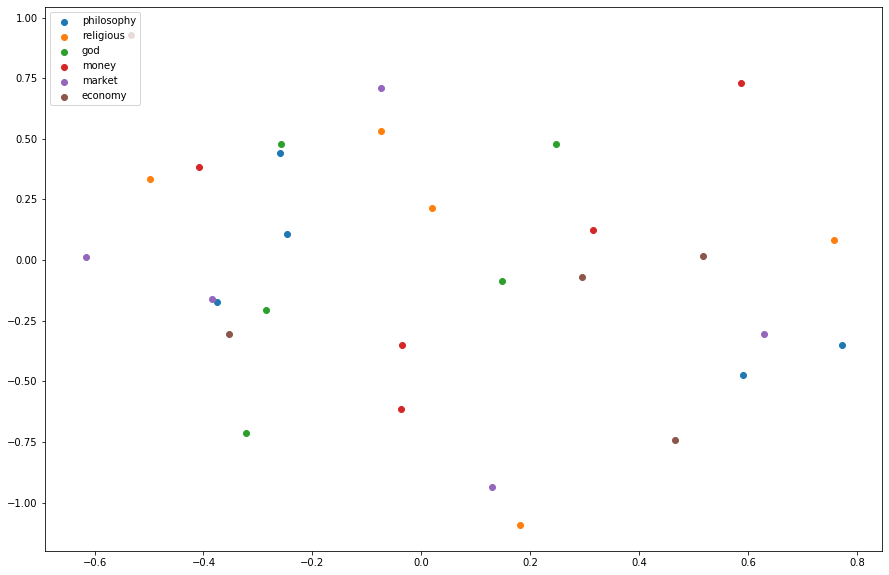

In [19]:
plt.figure(figsize=(15,10))
plt.scatter(philo[0],philo[1], label='philosophy')
plt.scatter(religious[0], religious[1], label='religious')
plt.scatter(god[0], god[1], label='god')
plt.scatter(money[0], money[1], label='money')
plt.scatter(market[0], market[1], label='market')
plt.scatter(economy[0], economy[1], label='economy')
plt.legend(loc='upper left')
plt.show()

In [20]:
M=2
reseau = torch.load('reseau_2.pth')
reseau.eval()

Reseau(
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [21]:
with torch.no_grad() :
   
    money = reseau(toVect(dictio.token2id['money'])).view(M,2).t().numpy()
    market = reseau(toVect(dictio.token2id['market'])).view(M,2).t().numpy()
    economy = reseau(toVect(dictio.token2id['economy'])).view(M,2).t().numpy()
    bible = reseau(toVect(dictio.token2id['bible'])).view(M,2).t().numpy()
    religious = reseau(toVect(dictio.token2id['religious'])).view(M,2).t().numpy()
    philo = reseau(toVect(dictio.token2id['philosophy'])).view(M,2).t().numpy()


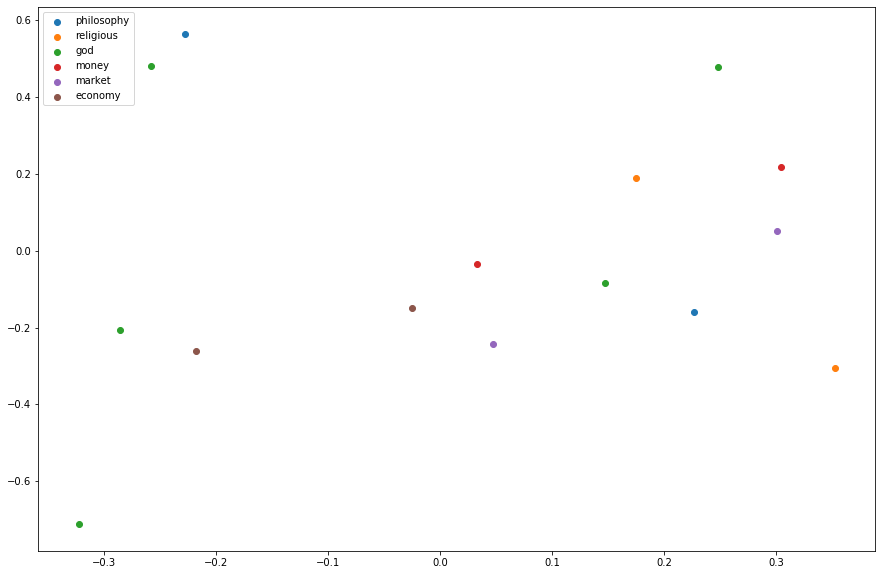

In [22]:
plt.figure(figsize=(15,10))
plt.scatter(philo[0],philo[1], label='philosophy')
plt.scatter(religious[0], religious[1], label='religious')
plt.scatter(god[0], god[1], label='god')
plt.scatter(money[0], money[1], label='money')
plt.scatter(market[0], market[1], label='market')
plt.scatter(economy[0], economy[1], label='economy')
plt.legend(loc='upper left')
plt.show()